
# Simulazione di caching basato su similarità di prompt (CLIP) con due politiche di eviction: LRU e LFU



In [82]:

import itertools
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.cluster import KMeans



### Setup device (MPS su Mac, altrimenti CPU)


In [83]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using Apple MPS device


## Gestione del dataset

In [84]:
from typing import Dict, List, Optional, Tuple, Union
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import random

class PromptDatasetManager:
    def __init__(self):
        self.df: pd.DataFrame = None
        self.emb_matrix: np.ndarray = None
        self.prompts_arr: np.ndarray = None
        self.embs_arr: np.ndarray = None
        self.user_to_idx: dict[str, np.ndarray] = {}
        self.session_to_idx: dict[tuple[str,int], np.ndarray] = {}

    def load_local_metadata(
        self,
        path: str,
        max_rows: Optional[int] = None,
        load_embeddings: bool = True
    ):
        # 1) Lettura Parquet
        cols = ['prompt','clip_emb','user_name','timestamp']
        table = pq.read_table(path, columns=cols)
        if max_rows:
            table = table.slice(0, max_rows)
        self.df = table.to_pandas()
        # 2) Timestamp -> datetime
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        # 3) Embedding matrix
        if load_embeddings:
            self.emb_matrix = np.vstack(self.df['clip_emb'].values).astype(np.float32)
        else:
            N = len(self.df)
            self.emb_matrix = np.zeros((N,0), dtype=np.float32)
        # 4) Prompt array
        self.prompts_arr = self.df['prompt'].to_numpy(dtype=object)
        # 5) Precompute sorted order and delta
        self._precompute_sorted()
        # 6) Global time order for sample_prompts
        self.time_sorted_idx = self.df.sort_values('timestamp').index.to_numpy()
        # 7) Build user->indices map
        self._build_user_indices()

    def _precompute_sorted(self):
        """
        Ordina per user_name, timestamp e calcola delta (minuti) tra record consecutivi.
        """
        order = self.df.sort_values(['user_name','timestamp']).index.to_numpy()
        self.sorted_idx = order
        users = self.df['user_name'].to_numpy()[order]
        # Estrai timestamps come datetime64[ns] e ordina
        times = self.df['timestamp'].to_numpy(dtype='datetime64[ns]')[order]
        # Converti a nanosecondi interi
        ts_int = times.astype('int64')
        # Differenze consecutive in ns -> minuti
        dt_ns = ts_int[1:] - ts_int[:-1]
        dt_min = dt_ns.astype(np.float32) / 1e9 / 60.0
        # Assegna delta
        delta = np.empty(len(order), dtype=np.float32)
        delta[0] = np.inf
        same = users[1:] == users[:-1]
        delta[1:] = np.where(same, dt_min, np.inf)
        self.sorted_delta = delta

    def _build_user_indices(self):
        groups = self.df.groupby('user_name', sort=False).indices
        self.user_to_idx = {u: np.asarray(idxs, dtype=np.int32) for u, idxs in groups.items()}


    # -----------------------
    #   FUNZIONI VELOCI
    # -----------------------

    def sample_sessions(
        self,
        gap: float,
        num_sessions: Optional[int] = None,
        max_prompts: Optional[int] = None,
        random_order: bool = False
    ) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Campiona sessioni definite da gap (minuti) tra prompt dello stesso user:
        - gap: soglia per separare sessioni
        - num_sessions=None -> tutte le sessioni (in ordine se random_order=False)
                       else -> campione casuale o primi
        - max_prompts=None -> tutti i prompt
                       else -> primi max_prompts di ogni sessione
        - random_order=False -> restituisce in ordine sequenziale di apparizione
        """
        # 1) breakpoints dove gap superato
        breaks = np.nonzero(self.sorted_delta > gap)[0]
        starts = np.concatenate(([0], breaks + 1))
        ends   = np.concatenate((breaks, [len(self.sorted_delta) - 1]))
        segments = list(zip(starts, ends))
        # 2) campionamento
        if num_sessions is not None and num_sessions < len(segments):
            if random_order:
                segments = random.sample(segments, num_sessions)
            else:
                segments = segments[:num_sessions]
        # 3) estrai batches
        out = []
        for s, e in segments:
            length = e - s + 1
            take = length if max_prompts is None else min(length, max_prompts)
            idxs = self.sorted_idx[s:s+take]
            out.append((self.prompts_arr[idxs], self.emb_matrix[idxs]))
        return out

    def sample_user_prompts(
        self,
        num_users: Optional[int] = None,
        random_order: bool = True,
        per_user: bool = False
    ) -> Union[List[Tuple[str, np.ndarray]], Dict[str, List[Tuple[str, np.ndarray]]]]:
        """
        Campiona prompt per un sottoinsieme di utenti:
        - num_users=None -> tutti gli utenti; altrimenti scegli num_users utenti (random o sequenziali)
        - per_user=False -> lista unica di (prompt, emb) concatenata per gli utenti selezionati
        - per_user=True  -> dict user->lista di (prompt, emb)
        - random_order=True/False determina l'ordine dei prompt per ciascun utente
        """
        # Seleziona utenti
        users = list(self.user_to_idx.keys())
        if num_users is not None and num_users < len(users):
            if random_order:
                selected_users = random.sample(users, num_users)
            else:
                selected_users = users[:num_users]
        else:
            selected_users = users

        # Prepara output
        if per_user:
            out: Dict[str, List[Tuple[str, np.ndarray]]] = {}
        else:
            out: List[Tuple[str, np.ndarray]] = []

        # Per ciascun utente selezionato, estrai tutti i prompt
        for user in selected_users:
            idxs = self.user_to_idx.get(user, np.array([], dtype=int))
            if idxs.size == 0:
                if per_user:
                    out[user] = []
                continue
            # eventualmente mescola i prompt per utente
            order = np.random.permutation(idxs) if random_order else idxs
            items = [(self.prompts_arr[i], self.emb_matrix[i]) for i in order]
            if per_user:
                out[user] = items
            else:
                out.extend(items)

        return out

    def sample_prompts(
        self,
        num_prompts: Optional[int] = None,
        random_order: bool = True
    ) -> List[Tuple[str, np.ndarray]]:
        """
        Campiona prompt globali:
        - num_prompts=None -> tutti
        - num_prompts=k    -> primi k in sequenza o k random
        - random_order=False -> sequenza cronologica globale (timestamp)
        - random_order=True  -> shuffle
        """
        N = len(self.prompts_arr)
        if random_order:
            k = min(num_prompts, N) if num_prompts is not None else N
            idxs = np.random.choice(N, size=k, replace=False)
        else:
            # indice solo per timestamp
            time_order = self.df.sort_values('timestamp').index.to_numpy()
            idxs = time_order if num_prompts is None else time_order[:num_prompts]
        return [(self.prompts_arr[i], self.emb_matrix[i]) for i in idxs]


manager = PromptDatasetManager()

In [85]:
manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Data/normalized_embeddings.parquet",
    max_rows=None # Limita per testare velocemente
)

print(f"Colonne disponibili: {list(manager.df.columns)}")
print((manager.df.head(5)))

Colonne disponibili: ['prompt', 'clip_emb', 'user_name', 'timestamp']
                                              prompt  \
0  a portrait of a female robot made from code, v...   
1  a portrait of a female robot made from a cloud...   
2      only memories remain, trending on artstation    
3                   dream swimming pool with nobody    
4           a dog doing weights. epic oil painting.    

                                            clip_emb  \
0  [0.0014396037, 0.009074121, -0.07621925, -0.01...   
1  [0.023341777, 0.014913292, -0.10948194, -0.000...   
2  [-0.018536763, -0.029404927, -0.048680052, 0.0...   
3  [0.019796269, -0.025657006, -0.03839434, 0.004...   
4  [0.026751772, 0.0011126306, -0.041311223, 0.04...   

                                           user_name                 timestamp  
0  0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd... 2022-08-20 11:56:00+00:00  
1  0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd... 2022-08-20 11:59:00+00:00  
2  0167cc490c

In [86]:
sessions = manager.sample_sessions(num_sessions=50, max_prompts=10, gap=30, random_order=True)
print(f"Loaded {len(sessions)} sessions.")
user_pairs = manager.sample_user_prompts(num_users=10, random_order=True, per_user=True)
print(f"Loaded {len(user_pairs)} user pairs.")
random_pairs = manager.sample_prompts(num_prompts=50, random_order=True)
print(f"Loaded {len(random_pairs)} random pairs.")


Loaded 50 sessions.
Loaded 10 user pairs.
Loaded 50 random pairs.


## Valutazione della similarità intra-sessione, extra-sessione e same-user

In [87]:
def compute_intra_session_sims(
    manager,
    num_sessions: Optional[int] = None,
    max_prompts: Optional[int] = None,
    session_gap: int = 30,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_sessions=None: tutte le sessioni, altrimenti ne estrae casuali/ordine.
    • Se max_prompts=None: tutti i prompt di ciascuna sessione, altrimenti limita.
    Ritorna array concatenato di dot‑product tra embeddings consecutive per sessione.
    """
    batches = manager.sample_sessions(
        num_sessions=num_sessions,
        max_prompts=max_prompts,
        random_order=random_order,
        gap=session_gap
    )
    sims_list = []
    for _, embs in batches:
        if embs.shape[0] < 2:
            continue
        M = embs if max_prompts is None else embs[:max_prompts]
        # dot tra righe consecutive
        dots = np.einsum('ij,ij->i', M[1:], M[:-1])
        sims_list.append(dots)
    return np.concatenate(sims_list) if sims_list else np.array([])


def compute_user_sims(
    manager,
    num_users: Optional[int] = None,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_prompts=None: per ogni utente prende tutti i suoi prompt in ordine.
    • Altrimenti estrae num_prompts per utente (random o sequenziale).
    Ritorna array concatenato dei dot‑product tra embeddings consecutive per utente.
    """
    user_dict = manager.sample_user_prompts(
        num_users=num_users,
        random_order=random_order,
        per_user=True
    )
    sims_list = []
    for items in user_dict.values():
        if len(items) < 2:
            continue
        embs = np.stack([emb for _, emb in items], axis=0)
        dots = np.einsum('ij,ij->i', embs[1:], embs[:-1])
        sims_list.append(dots)
    return np.concatenate(sims_list) if sims_list else np.array([])


def compute_random_sims(
    manager,
    num_prompts: Optional[int] = None,
    random_order: bool = True
) -> np.ndarray:
    """
    • Se num_prompts=None: prende tutti i prompt in ordine (o shuffled se random_order=True).
    • Altrimenti estrae num_prompts a caso o sequenziali.
    Ritorna array di dot‑product tra embeddings consecutive nell’array risultante.
    """
    items = manager.sample_prompts(
        num_prompts=num_prompts,
        random_order=random_order
    )
    if len(items) < 2:
        return np.array([])
    embs = np.stack([emb for _, emb in items], axis=0)
    return np.einsum('ij,ij->i', embs[1:], embs[:-1])


In [88]:
intra = compute_intra_session_sims(manager, num_sessions=None, max_prompts=None, session_gap=30, random_order=True)
print(f"Loaded {len(intra)} intra-session similarities.")
print(f"Mean intra-session similarity: {np.mean(intra) if len(intra) > 0 else 0.0}")
user = compute_user_sims(manager, num_users=None, random_order=True)
print(f"Loaded {len(user)} user similarities.")
print(f"Mean user similarity: {np.mean(user) if len(user) > 0 else 0.0}")
rand = compute_random_sims(manager, num_prompts=None, random_order=True)
print(f"Loaded {len(rand)} random similarities.")
print(f"Mean random similarity: {np.mean(rand) if len(rand) > 0 else 0.0}")

Loaded 1854300 intra-session similarities.
Mean intra-session similarity: 0.7907183170318604
Loaded 1989708 user similarities.
Mean user similarity: 0.44603240489959717
Loaded 1999999 random similarities.
Mean random similarity: 0.3239522874355316


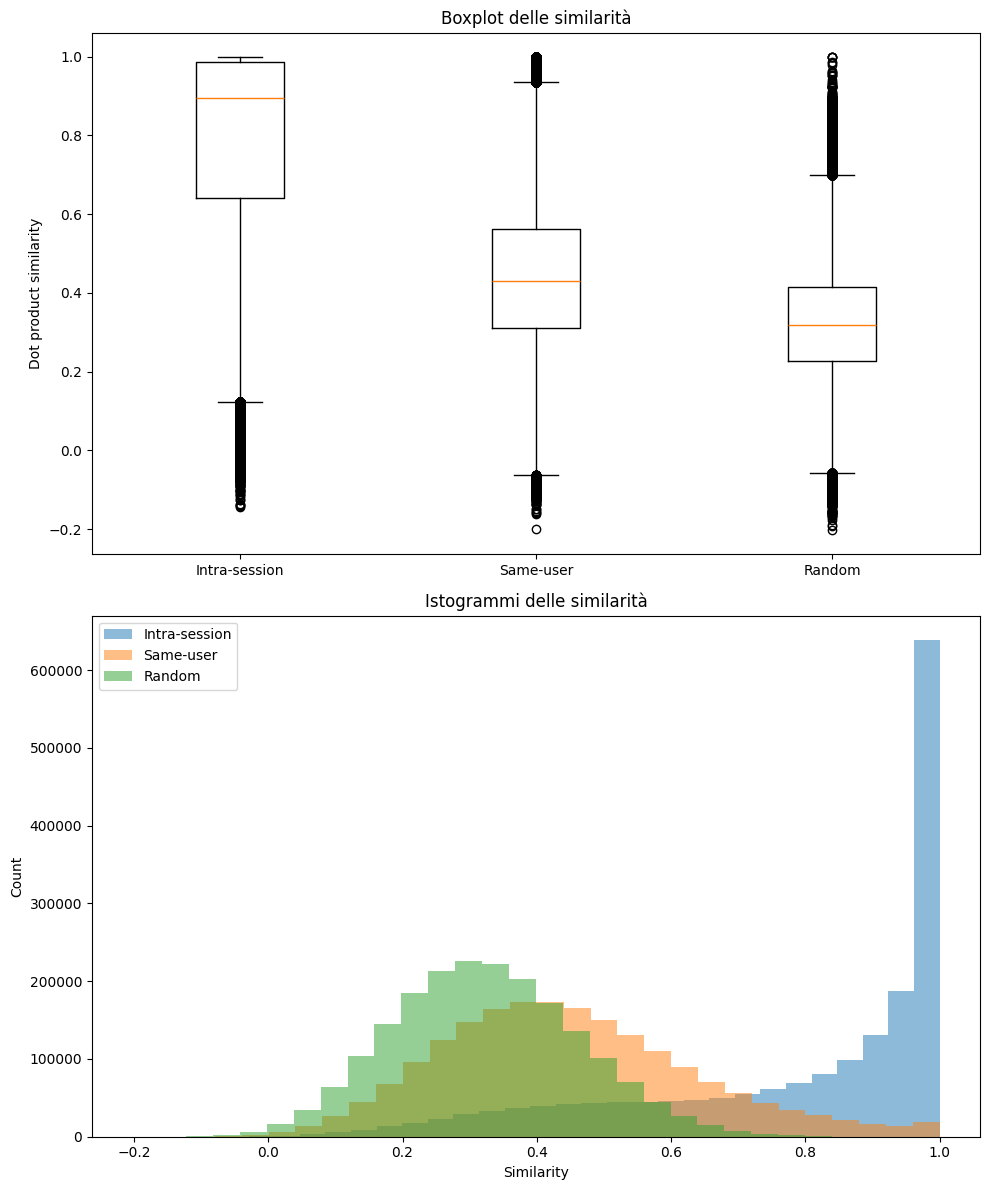

In [89]:

# Histo + boxplot
def plot_distributions(intra, user, rand):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Boxplot comparativo\    
    axs[0].boxplot([intra, user, rand], tick_labels=['Intra-session', 'Same-user', 'Random'])
    axs[0].set_title('Boxplot delle similarità')
    axs[0].set_ylabel('Dot product similarity')

    # Istogrammi affiancati
    N, bins = 1, 30
    axs[1].hist(intra, bins=bins, alpha=0.5, label='Intra-session')
    axs[1].hist(user, bins=bins, alpha=0.5, label='Same-user')
    axs[1].hist(rand, bins=bins, alpha=0.5, label='Random')
    axs[1].set_title('Istogrammi delle similarità')
    axs[1].set_xlabel('Similarity')
    axs[1].set_ylabel('Count')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_distributions(intra, user, rand)


Loaded 6 session gaps.
Means by gap: [np.float32(0.7963676), np.float32(0.79320544), np.float32(0.79146725), np.float32(0.7907183), np.float32(0.78964514), np.float32(0.7887222)]


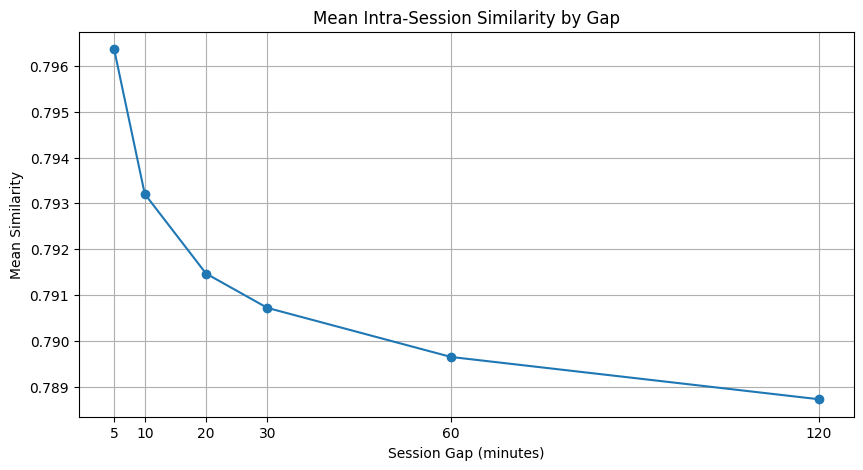

In [90]:
session_gaps = [5, 10, 20, 30, 60, 120]

sims_by_gap = [np.mean(compute_intra_session_sims(manager, num_sessions=None, session_gap=gap, max_prompts=None)) for gap in session_gaps]
print (f"Loaded {len(sims_by_gap)} session gaps.")
print (f"Means by gap: {sims_by_gap}")
# plot sims_by_gap
plt.figure(figsize=(10, 5))
plt.plot(session_gaps, sims_by_gap, marker='o')
plt.title('Mean Intra-Session Similarity by Gap')
plt.xlabel('Session Gap (minutes)')
plt.ylabel('Mean Similarity')
plt.xticks(session_gaps)
plt.grid()
plt.show()

## Cache similarity con politiche di eviction

LRU (Least Recently Used) e LFU (Least Frequently Used) e TTL (Time To Live) per la gestione della cache.

In [91]:
import numpy as np
import faiss
from collections import OrderedDict, defaultdict
from typing import Callable, Dict, List, Tuple, Optional

class SimilarityIndex:
    """
    Wraps a FAISS inner-product index for fast nearest-neighbor search over embeddings.
    Maintains mapping from keys to embeddings and back.
    """
    def __init__(self, dim: int, use_faiss: bool = True):
        self.dim = dim
        self.use_faiss = use_faiss
        # key list in same order as index vectors
        self.keys: List[str] = []
        # linear store for fallback
        self.embs: List[np.ndarray] = []
        if self.use_faiss:
            # IndexFlatIP for inner-product similarity
            self.index = faiss.IndexFlatIP(dim)

    def add(self, key: str, emb: np.ndarray):
        """Add a new vector to the index."""
        vec = emb.reshape(1, -1).astype(np.float32)
        self.keys.append(key)
        self.embs.append(emb)
        if self.use_faiss:
            self.index.add(vec)

    def remove(self, key: str):
        """Remove a key (and its embedding) from the index. Requires rebuild."""
        # find position
        try:
            idx = self.keys.index(key)
        except ValueError:
            return
        # drop
        self.keys.pop(idx)
        self.embs.pop(idx)
        if self.use_faiss:
            # rebuild index
            self.index.reset()
            all_vecs = np.stack(self.embs).astype(np.float32)
            if len(all_vecs):
                self.index.add(all_vecs)

    def query(self, emb: np.ndarray, topk: int = 1) -> Tuple[Optional[str], float]:
        """
        Search for the most similar cached embedding to `emb`.
        Returns (best_key, best_sim).
        If cache empty, returns (None, -inf).
        """
        if not self.keys:
            return None, -np.inf
        vec = emb.reshape(1, -1).astype(np.float32)
        if self.use_faiss:
            D, I = self.index.search(vec, min(len(self.keys), topk))
            best_sim = float(D[0,0])
            best_key = self.keys[I[0,0]]
            return best_key, best_sim
        else:
            # linear scan
            best_key, best_sim = None, -np.inf
            for k, e in zip(self.keys, self.embs):
                sim = float(np.dot(e, emb))
                if sim > best_sim:
                    best_sim = sim
                    best_key = k
            return best_key, best_sim

class BaseSimilarityCache:
    """
    Base class for similarity caches. You can register observers
    that riceveranno eventi: 'hit', 'miss', 'add', 'evict'.
    """
    def __init__(self,
                 capacity: int,
                 threshold: float,
                 dim: int,
                 use_faiss: bool = True):
        self.capacity = capacity
        self.threshold = threshold
        self.index = SimilarityIndex(dim, use_faiss)
        self._observers: List[Callable[[str, str, 'BaseSimilarityCache'], None]] = []

    def register_observer(self, fn: Callable[[str, str, 'BaseSimilarityCache'], None]):
        """fn(event_type, key, cache)"""
        self._observers.append(fn)

    def _notify(self, event_type: str, key: Optional[str]):
        for fn in self._observers:
            fn(event_type, key, self)

    def query(self, key: str, emb: np.ndarray) -> bool:
        best_key, best_sim = self.index.query(emb)
        if best_sim >= self.threshold:
            self._on_hit(best_key)
            self._notify('hit', best_key)
            return True
        else:
            self._notify('miss', key)
            self._on_miss(key, emb)
            return False

    def _on_miss(self, key: str, emb: np.ndarray):
        if len(self.index.keys) >= self.capacity:
            ev = self._select_eviction()
            self.index.remove(ev)
            self._notify('evict', ev)
            self._on_evict(ev)
        self.index.add(key, emb)
        self._notify('add', key)
        self._on_add(key)

    # Subclasses must implement:
    def _on_hit(self, key: str):        raise NotImplementedError
    def _on_add(self, key: str):        pass
    def _on_evict(self, key: str):      pass
    def _select_eviction(self) -> str:  raise NotImplementedError


In [92]:

class LRUCache(BaseSimilarityCache):
    """Least-Recently-Used eviction policy."""
    def __init__(self, capacity: int, threshold: float, dim: int, use_faiss: bool = True):
        super().__init__(capacity, threshold, dim, use_faiss)
        from collections import OrderedDict
        self.order = OrderedDict()  # key -> None

    def _on_hit(self, key: str):
        # move to end = most recently used
        self.order.move_to_end(key)

    def _on_add(self, key: str):
        self.order[key] = None

    def _on_evict(self, key: str):
        del self.order[key]

    def _select_eviction(self) -> str:
        # least recently used = first key
        return next(iter(self.order))

class LFUCache(BaseSimilarityCache):
    """Least-Frequently-Used eviction policy."""
    def __init__(self, capacity: int, threshold: float, dim: int, use_faiss: bool = True):
        super().__init__(capacity, threshold, dim, use_faiss)
        self.freq = defaultdict(int)

    def _on_hit(self, key: str):
        self.freq[key] += 1

    def _on_add(self, key: str):
        self.freq[key] = 1

    def _on_evict(self, key: str):
        del self.freq[key]

    def _select_eviction(self) -> str:
        # key with minimal freq
        return min(self.freq, key=lambda k: self.freq[k])

class TTLCache(BaseSimilarityCache):
    """Time-to-Live eviction: removes entries not seen in last ttl requests."""
    def __init__(
        self,
        capacity: int,
        threshold: float,
        dim: int,
        ttl: int,
        use_faiss: bool = True
    ):
        super().__init__(capacity, threshold, dim, use_faiss)
        self.ttl = ttl
        self.time = 0
        self.last_seen = {}  # key -> last request time

    def query(self, key: str, emb: np.ndarray) -> bool:
        # expire old entries first
        expired = [k for k, t in self.last_seen.items() if self.time - t > self.ttl]
        for k in expired:
            self.index.remove(k)
            del self.last_seen[k]
        hit = super().query(key, emb)
        # update time
        self.time += 1
        return hit

    def _on_hit(self, key: str):
        self.last_seen[key] = self.time

    def _on_add(self, key: str):
        self.last_seen[key] = self.time

    def _select_eviction(self) -> str:
        # not used: eviction on miss picks oldest by time
        return min(self.last_seen, key=lambda k: self.last_seen[k])


In [105]:
class RNDLRUCache(LRUCache):
    """Randomized LRU where threshold varies at each query."""
    def __init__(self, capacity, threshold, dim, use_faiss=True, min_threshold=0.5, max_threshold=1.0):
        super().__init__(capacity, threshold, dim, use_faiss)
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold

    def query(self, key: str, emb: np.ndarray) -> bool:
        # random threshold every time
        self.threshold = np.random.uniform(self.min_threshold, self.max_threshold)
        return super().query(key, emb)


class RNDTTLCache(TTLCache):
    """Randomized TTL with varying similarity threshold per request."""
    def __init__(self, capacity, threshold, dim, ttl, use_faiss=True, min_threshold=0.5, max_threshold=1.0):
        super().__init__(capacity, threshold, dim, ttl, use_faiss)
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold

    def query(self, key: str, emb: np.ndarray) -> bool:
        expired = [k for k, t in self.last_seen.items() if self.time - t > self.ttl]
        for k in expired:
            self.index.remove(k)
            del self.last_seen[k]
        # random threshold
        self.threshold = np.random.uniform(self.min_threshold, self.max_threshold)
        hit = BaseSimilarityCache.query(self, key, emb)
        self.time += 1
        return hit


Exception in thread Thread-119 (run_live):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/Users/tella/Workspace/Inria/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/xc/7hdkthds19g1p1r2m6m9pnxm0000gn/T/ipykernel_1284/2123073000.py", line 129, in run_live
    cache.query(key, emb)
    ~~~~~~~~~~~^^^^^^^^^^
  File "/var/folders/xc/7hdkthds19g1p1r2m6m9pnxm0000gn/T/ipykernel_1284/1566059120.py", line 28, in query
    hit = BaseSimilarityCache.query(self, key, emb)
  File "/var/folders/xc/7hdkthds19g1p1r2m6m9pnxm0000gn/T/ipykernel_12

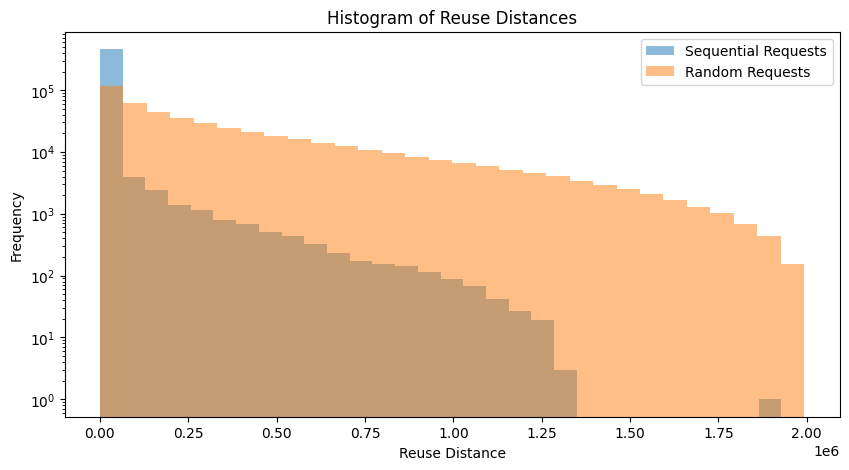

In [102]:

def compute_reuse_dist(requests: List[str]) -> List[int]:
    last = {}
    deltas = []
    for i, p in enumerate(requests):
        if p in last:
            deltas.append(i - last[p])
        last[p] = i
    return deltas

seq_requests = manager.sample_prompts(num_prompts=None, random_order=False)
rand_requests = manager.sample_prompts(num_prompts=None, random_order=True)

reuse_seq = compute_reuse_dist([p for p,_ in seq_requests])
reuse_rand = compute_reuse_dist([p for p,_ in rand_requests])

# Plot histogram of reuse distances (log scale)
plt.figure(figsize=(10, 5))
plt.hist(reuse_seq, bins=30, alpha=0.5, label='Sequential Requests', log=True)
plt.hist(reuse_rand, bins=30, alpha=0.5, label='Random Requests', log=True)
plt.title('Histogram of Reuse Distances')
plt.xlabel('Reuse Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [107]:
import panel as pn
import holoviews as hv
from holoviews.streams import Pipe
import numpy as np
import threading, time
from holoviews import opts

pn.extension('holoviews')
hv.extension('bokeh')

# Variabili globali di stato
history = []
current_idx = 0
stop_event = threading.Event()
cache = None
requests = []
start_time = None

# --- Widgets ---
policy_select   = pn.widgets.Select(name='Policy', options=['LRU','LFU','TTL','RNDLRU','RNDTTL'], value='LRU')
capacity_slider = pn.widgets.IntSlider(name='Capacity', start=50, end=2000, step=50, value=500)
threshold_slider= pn.widgets.FloatSlider(name='Threshold', start=0.5, end=1.0, step=0.05, value=0.8)
ttl_slider      = pn.widgets.IntSlider(name='TTL', start=10, end=500, step=10, value=100)
trace_select    = pn.widgets.RadioButtonGroup(name='Trace', options=['Sequential','Random'], button_type='primary')
start_button    = pn.widgets.Button(name='Start Live Simulation', button_type='success')
stop_button     = pn.widgets.Button(name='Stop & Reset', button_type='danger')

text_hit_rate   = pn.widgets.StaticText(name='Hit Rate', value='0.0%')
text_slide_rate = pn.widgets.StaticText(name='Sliding Hit Rate (1k)', value='0.0%')
text_occupancy  = pn.widgets.StaticText(name='Cache Occupancy', value='0/0 (0.0%)')
text_rps        = pn.widgets.StaticText(name='Requests/sec', value='0.0')

hv.opts.defaults(opts.Curve(width=800, height=400, show_grid=True, tools=[]))
stream = Pipe(data=[])

TRACE_LEN = 5000
seq_requests = manager.sample_prompts(num_prompts=TRACE_LEN, random_order=False)
rand_requests = manager.sample_prompts(num_prompts=TRACE_LEN, random_order=True)
dim = manager.emb_matrix.shape[1]

def update_plot(data):
    if not data:
        empty_x, empty_y = [], []
        curve_hr = hv.Curve((empty_x, empty_y), 'Request', 'Hit Rate (%)', label='Hit Rate (%)')
        curve_occ = hv.Curve((empty_x, empty_y), 'Request', 'Occupancy (%)', label='Occupancy (%)')
        return (curve_hr * curve_occ).opts(
            width=800, height=400, show_grid=True,
            ylim=(0, 100), xlim=(1, TRACE_LEN),
            legend_position='top_right',
            tools=[]
        )

    xs, hrs_percent, occs_percent = zip(*data)

    curve_hr = hv.Curve((xs, hrs_percent), 'Request', 'Hit Rate (%)', label='Hit Rate (%)').opts(line_width=2)
    curve_occ = hv.Curve((xs, occs_percent), 'Request', 'Occupancy (%)', label='Occupancy (%)').opts(line_width=2, line_dash='dashed')

    return (curve_hr * curve_occ).opts(
        width=800, height=400, show_grid=True,
        ylim=(0, 100), xlim=(1, max(xs)),
        xlabel='Request',
        legend_position='top_right',
        tools=[]
    )


dmap = hv.DynamicMap(update_plot, streams=[stream])

def push_to_pipe(event_type, key, c, idx):
    # hits tra 0 e 1
    hits = (history[-1][1] * (idx - 1) if history else 0) + (1 if event_type == 'hit' else 0)
    hr = hits / idx
    occ = len(c.index.keys) / c.capacity

    # ⬇️ Salva valori GREZZI (0-1)
    history.append((idx, hr, occ, event_type == 'hit'))

    # Sliding Hit Rate ultimi 1000 (0-1)
    window = history[-1000:] if len(history) > 1000 else history
    sliding_hits = sum(1 for h in window if h[3])
    sliding_hr = sliding_hits / len(window) if window else 0.0

    text_hit_rate.value = f"{hr * 100:.1f}%"
    text_slide_rate.value = f"{sliding_hr * 100:.1f}%"
    text_occupancy.value = f"{len(c.index.keys)}/{c.capacity} ({occ * 100:.1f}%)"

    elapsed = time.time() - start_time
    rps = idx / elapsed if elapsed > 0 else 0.0
    text_rps.value = f"{rps:.1f}"

    if idx % 100 == 0 or idx == len(requests):
        stream.send([(i, h * 100, o * 100) for i, h, o, _ in history])


def setup_cache():
    global cache, requests
    cap = capacity_slider.value
    th = threshold_slider.value
    ttl = ttl_slider.value
    trace = seq_requests if trace_select.value=='Sequential' else rand_requests
    requests = trace
    policy = policy_select.value
    if policy == 'LRU':
        cache = LRUCache(cap, th, dim, use_faiss=True)
    elif policy == 'LFU':
        cache = LRUCache(cap, th, dim, use_faiss=False)
    elif policy == 'TTL':
        cache = TTLCache(cap, th, dim, ttl, use_faiss=True)
    elif policy == 'RNDLRU':
        cache = RNDLRUCache(cap, th, dim, use_faiss=True)
    elif policy == 'RNDTTL':
        cache = RNDTTLCache(cap, th, dim, ttl, use_faiss=True)

    def observer(event_type, key, c):
        push_to_pipe(event_type, key, c, current_idx)

    cache.register_observer(observer)

def run_live():
    global history, start_time, current_idx
    history.clear()
    cache.index = cache.index
    start_time = time.time()
    stop_event.clear()
    for idx, (key, emb) in enumerate(requests, start=1):
        if stop_event.is_set():
            break
        current_idx = idx
        cache.query(key, emb)

def on_start(event):
    setup_cache()
    stream.send([(0, 0, 0)])
    threading.Thread(target=run_live, daemon=True).start()

def on_stop(event):
    global current_idx, history
    stop_event.set()
    history.clear()
    current_idx = 0
    text_hit_rate.value = '0.0%'
    text_slide_rate.value = '0.0%'
    text_occupancy.value = '0/0 (0.0%)'
    text_rps.value = '0.0'
    stream.send([(0, 0, 0)])
    if cache:
        cache.index = cache.index

start_button.on_click(on_start)
stop_button.on_click(on_stop)

dashboard = pn.Column(
    pn.Row(policy_select),
    pn.Row(start_button, stop_button, trace_select),
    pn.Row(text_hit_rate, text_slide_rate, text_occupancy, text_rps),
    pn.panel(dmap),
    pn.Row(capacity_slider, threshold_slider, ttl_slider)
)

dashboard.servable(title="Live Similarity Cache Simulator")


BokehModel(combine_events=True, render_bundle={'docs_json': {'8be0c035-269e-4418-b7a1-12581ad91f13': {'version…

### Chaching test

In [99]:
def faiss_search_similarity(
    index: faiss.IndexFlatIP,
    query: np.ndarray,
    topk: int = 10
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Esegue una ricerca di similarità usando FAISS.
    Ritorna le distanze e gli indici dei top-k risultati.
    La ricerca la fa su tutto il dataset indicizzato.
    - index: istanza di faiss.IndexFlatIP indicizzata
    - query: vettore di query (1D o 2D con una riga)
    - topk: numero di risultati da restituire
    """
    query = query.reshape(1, -1).astype(np.float32)
    distances, indices = index.search(query, topk)
    return distances[0], indices[0]

# Create FAISS index from the embedding matrix
dim = manager.emb_matrix.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(manager.emb_matrix.astype(np.float32))

# Stampa le prime 10 similarità per un prompt casuale
prompt, emb = manager.sample_prompts(num_prompts=1, random_order=True)[0]
print(f"Prompt: {prompt}")
distances, indices = faiss_search_similarity(index, emb, topk=10)
print("Top-10 Similarities:")
for i, (dist, idx) in enumerate(zip(distances, indices)):
    if idx == -1:  # -1 indica che non ci sono risultati
        continue
    print(f"{i+1}: {manager.prompts_arr[idx]} (Similarity: {dist:.4f})")
print("Total prompts in index:", len(manager.prompts_arr))


Prompt: digital artwork of a medieval tracted chariot built by ferrari, inspirated by ferrari's trending on artstation 
Top-10 Similarities:
1: digital artwork of a medieval tracted chariot built by ferrari, inspirated by ferrari's trending on artstation  (Similarity: 1.0000)
2: digital artwork of a medieval chariot built by ferrari, trending on artstation  (Similarity: 0.9795)
3: digital artwork of a medieval chariot built by ferrari, trending on artstation  (Similarity: 0.9795)
4: digital artwork of a medieval chariot built by renault, trending on artstation  (Similarity: 0.9353)
5: a concept art of a vehicle, ferrari, artstation  (Similarity: 0.8432)
6: digital artwork of a ferrari transformers, trending on artstation  (Similarity: 0.8235)
7: a concept art of a medieval vehicle by renault, artstation  (Similarity: 0.8204)
8: digital illustration of a ferrari starship, artstation  (Similarity: 0.8050)
9: a concept art of a vehicle, medieval fantastic, artstation  (Similarity: 0.8040)